# Mutual information with batch in IDEAS features

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load common_.py
from common import *

In [3]:
from sklearn.feature_selection import mutual_info_classif
from ehv import load

In [4]:
df = load.load_raw_ideas_dir(
    Path("/data/weizmann/EhV/high_time_res"), 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/representations/ideas_features/"), 
    "ALL", 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/cell_populations/manual_gating/"))
df = load.remove_unwanted_features(df)
df = load.tag_columns(df)

In [5]:
df = df[df["meta_label_COI"]]

In [6]:
df.head()

,meta_Object Number,feat_Area_M01,feat_Area_M03,feat_Area_M04,feat_Area_M06,feat_Area_M07,feat_Area_M09,feat_Area_M11,feat_Area_MC,feat_Aspect Ratio_M01,...,feat_Intensity_M02_Ch02,feat_Similarity_M01_Ch02_Ch03,meta_timepoint,meta_replicate,meta_group,meta_label_COI,meta_label_MCP_NEG_PSBA_POS,meta_label_MCP_POS_PSBA_POS,meta_label_MCP_POS_PSBA_NEG,meta_label_MCP_NEG_PSBA_NEG
0,0,27.333334,8.666667,0.0,18.444445,23.666666,25.111111,25.333334,30.777779,0.791100,...,264.683319,1.518726,5,R2,Ctrl,True,True,False,False,False
1,1,48.111111,11.888889,0.0,38.888889,38.000000,43.444443,47.444443,58.444443,0.667636,...,288.316956,1.021137,5,R2,Ctrl,True,True,False,False,False
3,3,34.000000,8.000000,0.0,8.555555,22.666666,28.666666,23.111111,36.555557,0.790068,...,553.474365,1.700220,5,R2,Ctrl,True,True,False,False,False
6,6,43.888889,13.444445,0.0,27.000000,31.111111,37.222221,33.888889,48.666668,0.696534,...,1164.375000,2.164527,5,R2,Ctrl,True,True,False,False,False
7,7,30.000000,0.000000,0.0,18.111111,22.000000,34.888889,35.000000,38.111111,0.904152,...,56.716465,1.212063,5,R2,Ctrl,True,True,False,False,False


In [7]:
discrete_features_map = {
    'feat_Area': False,
    'feat_Aspect Ratio': False,
    'feat_Aspect Ratio Intensity': False,
    'feat_Modulation': False,
    'feat_Contrast': False,
    'feat_Gradient RMS': False,
    'feat_Intensity': False,
    'feat_Mean Pixel': False,
    'feat_Median Pixel': False,
    'feat_Max Pixel': False,
    'feat_Length': True,
    'feat_Width': True,
    'feat_Height': True,
    'feat_Bright Detail Intensity R3': False,
    'feat_Similarity': False
}

In [8]:
import re
reg = r"^(feat_[^_]+)_.+$"

In [9]:
discrete_features = df.filter(regex="feat").columns.map(lambda col: discrete_features_map[re.match(reg, col).group(1)]).values.astype("bool")

# Mutual information of features with biological replicate

We expect to see no mutual information between features and biological replicate as all replicates should be very similar.

In [45]:
n = 10000

In [46]:
mi_replicate = {}
for idx, gdf in df.groupby("meta_group"):
    indices = numpy.random.choice(len(gdf), size=n, replace=False)
    mi_replicate[idx] = mutual_info_classif(X=gdf.filter(regex="feat").iloc[indices].values, y=gdf["meta_replicate"].iloc[indices])#, discrete_features=discrete_features)

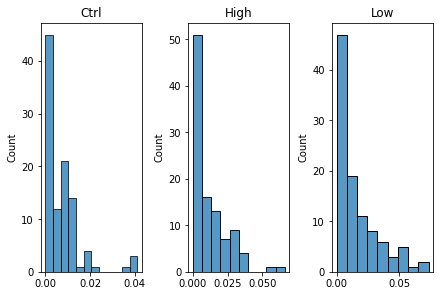

In [52]:
fig, axes = plt.subplots(1, 3, constrained_layout=True)
axes = axes.ravel()
for i, (k, v) in enumerate(mi_replicate.items()):
    axes[i].set_title(k)
    seaborn.histplot(v, ax=axes[i])

Maximal MI is in this case ~0.08. This is very low.

# Mutual information of features with timepoint

In [53]:
mi_timepoint = {}
for idx, gdf in df.groupby("meta_group"):
    indices = numpy.random.choice(len(gdf), size=n, replace=False)
    mi_timepoint[idx] = mutual_info_classif(X=df.filter(regex="feat").iloc[indices].values, y=df["meta_timepoint"].iloc[indices])

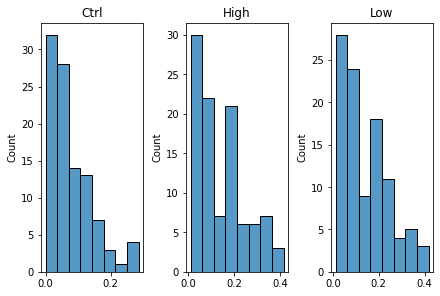

In [54]:
fig, axes = plt.subplots(1, 3, constrained_layout=True)
axes = axes.ravel()
for i, (k, v) in enumerate(mi_timepoint.items()):
    axes[i].set_title(k)
    seaborn.histplot(v, ax=axes[i])

<BarContainer object of 20 artists>

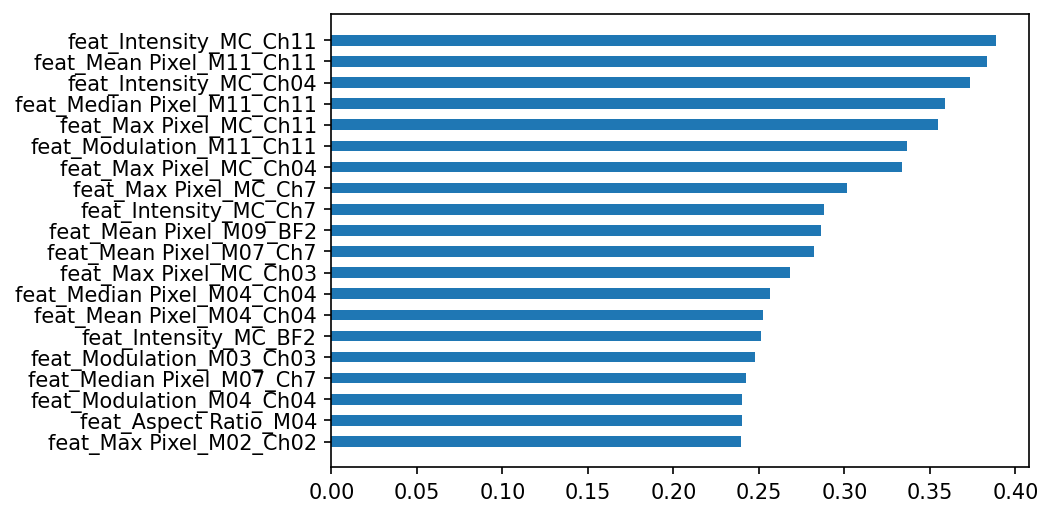

In [44]:
fig, ax = plt.subplots(dpi=150)
fig, axes = plt.subplots(1, 3, constrained_layout=True)
axes = axes.ravel()
for i, (k, v) in enumerate(mi_timepoint.items()):
    args = numpy.argsort(mi_timepoint)[-20:]
    ax.barh(y=df.filter(regex="feat").columns[args], width=mi_timepoint[args], height=0.5)

All features have some mutual information with the timepoint. This is not unexpected as we expect to see changes as time progresses.